# Merge data

In [1]:
import pandas as pd
import numpy as np

def merge_csv_files(folder1, folder2, output_folder):
    import os

    files1 = {f: os.path.join(folder1, f) for f in os.listdir(folder1) if f.endswith('.csv')}
    files2 = {f: os.path.join(folder2, f) for f in os.listdir(folder2) if f.endswith('.csv')}
    for filename in set(files1.keys()).intersection(files2.keys()):
        df1 = pd.read_csv(files1[filename])
        df2 = pd.read_csv(files2[filename])
        if df1.shape[1] > 1 and df2.shape[1] >1:
            df2.insert(2, 'y_pred', df1.iloc[:, 1])
        else:
            print(f"Skipping {filename} due to unexpected column structure.")
            continue
        output_file = os.path.join(output_folder, filename)
        df2.to_csv(output_file, index=False)
        print(f"Merged {filename} and saved to {output_file}")


if __name__ == "__main__":
    folder1 = './cal_data'
    folder2 = './pred_data'
    output_folder = './merged_data'
    
    import os
    os.makedirs(output_folder, exist_ok=True)
    merge_csv_files(folder2,folder1,  output_folder)

Merged 573_0.001.csv and saved to ./merged_data\573_0.001.csv
Merged 673_0.001.csv and saved to ./merged_data\673_0.001.csv
Merged 623_0.010.csv and saved to ./merged_data\623_0.010.csv
Merged 673_0.010.csv and saved to ./merged_data\673_0.010.csv
Merged 673_1.000.csv and saved to ./merged_data\673_1.000.csv
Merged 623_0.001.csv and saved to ./merged_data\623_0.001.csv
Merged 573_1.000.csv and saved to ./merged_data\573_1.000.csv
Merged 523_0.100.csv and saved to ./merged_data\523_0.100.csv
Merged 523_0.010.csv and saved to ./merged_data\523_0.010.csv
Merged 673_0.100.csv and saved to ./merged_data\673_0.100.csv
Merged 623_1.000.csv and saved to ./merged_data\623_1.000.csv
Merged 573_0.010.csv and saved to ./merged_data\573_0.010.csv
Merged 523_0.001.csv and saved to ./merged_data\523_0.001.csv
Merged 573_0.100.csv and saved to ./merged_data\573_0.100.csv
Merged 523_1.000.csv and saved to ./merged_data\523_1.000.csv
Merged 623_0.100.csv and saved to ./merged_data\623_0.100.csv


## Curve figure

In [2]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages


data_pred_dir = "./merged_data"   
data_org_dir  = "./alloy_dataset/AQ80"     
out_dir = "./fig_out"
os.makedirs(out_dir, exist_ok=True)
pdf_path = os.path.join(out_dir, "group_plots.pdf")

pattern = re.compile(r"^(\d+)_([0-9.]+)\.csv$", re.IGNORECASE)


mpl.rcParams.update({
    "font.family": "Arial",
    "font.size": 12,
    "axes.linewidth": 1.2,
    "axes.labelsize": 12,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "legend.frameon": False,
})

custom_colors = [
    '#C93735',
    '#F8AB61',
    '#78A9CD',
    '#333A8C',
    "#C92CA2"
]

colors = np.array(custom_colors[:])

def load_csv_group(data_dir, needed_cols):
    "" "read csv file and return { (T, sr): DataFrame }"""
    data = {}
    temps_set, srs_set = set(), set()
    for path in glob.glob(os.path.join(data_dir, "*.csv")):
        name = os.path.basename(path)
        m = pattern.match(name)
        if not m:
            continue
        T_str, sr_str = m.groups()
        T, sr = int(T_str), float(sr_str)

        try:
            df = pd.read_csv(path)
        except Exception as e:
            print(f"[Skip] read error: {name} -> {e}")
            continue

        if not set(needed_cols).issubset(df.columns):
            print(f"[Skip] missing columns: {name} requires columns {needed_cols}")
            continue

        df = df[needed_cols].dropna().reset_index(drop=True)
        if df.empty:
            print(f"[Skip] empty data: {name}")
            continue
        data[(T, sr)] = df
        temps_set.add(T)
        srs_set.add(sr)
    return data, sorted(temps_set), sorted(srs_set)

# ======= read data =======
data_pred, temps1, srs1 = load_csv_group(data_pred_dir, ["y_true", "y_pred", "y_cal"])

data_org,  temps2, srs2 = load_csv_group(data_org_dir,  ["strain", "stress"])

temps = sorted(set(temps1) & set(temps2))
srs   = sorted(set(srs1) & set(srs2))

if not data_pred or not data_org:
    raise RuntimeError("No valid CSV files parsed, please check paths and column names!")

print(f"✅ Parsed {len(data_pred)} groups of prediction data, {len(data_org)} groups of experimental data")
print("Temperature list:", temps)
print("Strain rate list:", srs)



✅ Parsed 16 groups of prediction data, 16 groups of experimental data
Temperature list: [523, 573, 623, 673]
Strain rate list: [0.001, 0.01, 0.1, 1.0]


In [5]:
custom_color_map = {
}

# plot_y = "y_pred"
plot_y = "y_cal"

def plot_by_strainrate(data_pred, data_org, temps, srs, out_dir, pdf=None, custom_color_map=None):
    for sr in srs:
        fig, ax = plt.subplots(figsize=(3.5, 2.8))
        for i, T in enumerate(temps):
            key = (T, sr)
            if key not in data_pred or key not in data_org:
                continue
            df_pred, df_org = data_pred[key], data_org[key]

            curve_color = None
            if custom_color_map and key in custom_color_map:
                curve_color = custom_color_map[key]
            else:
                curve_color = colors[i % len(colors)] 

            ax.plot(np.linspace(0.05, 0.8, len(df_pred)), df_pred["y_true"],
                    color=curve_color, linewidth=1.8, linestyle="-",
                    label=f"T={T}K exp")

            ax.scatter(np.linspace(0.05, 0.8, len(df_pred)), df_pred[plot_y],
                    color=curve_color, marker="o", s=20, label=f"T={T}K pred")

        ax.set_xlabel("True strain")
        ax.set_ylabel("True stress (MPa)")
        ax.set_xlim(0.0, 0.85)
        ax.set_ylim(0, None)
        ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
        ax.tick_params(axis='x', which='both', bottom=True, top=False)
        ax.tick_params(axis='y', which='both', left=True, right=False)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        

        fig.savefig(os.path.join(out_dir, f"strainrate_{sr}.png"),
                    dpi=300, bbox_inches="tight")
        if pdf is not None:
            pdf.savefig(fig)
        plt.close(fig)

with PdfPages(pdf_path) as pdf:
    
    plot_by_strainrate(data_pred, data_org, temps, srs, out_dir, pdf, custom_color_map)

print(f"✅ Figures have been saved: {pdf_path}")

✅ Figures have been saved: ./fig_out\group_plots.pdf


## MSE bar figure


In [4]:
def plot_rmse_by_strainrate_bar(data_pred, temps, srs, out_dir, pdf=None, custom_color_map=None):
    os.makedirs(out_dir, exist_ok=True)
    bar_w = 0.35  

    all_rmse_records = []

    for sr in srs:
        temp_list, rmse_pred_list, rmse_cal_list = [], [], []

        for T in temps:
            key = (T, sr)
            if key not in data_pred:
                continue
            df = data_pred[key]

            rmse_pred = mean_squared_error(df["y_true"], df["y_pred"])
            rmse_cal  = mean_squared_error(df["y_true"], df["y_cal"])

            temp_list.append(T)
            rmse_pred_list.append(rmse_pred)
            rmse_cal_list.append(rmse_cal)

            all_rmse_records.append({
                "Temperature (K)": T,
                "Strain rate (s^-1)": sr,
                "MSE_pred": rmse_pred,
                "MSE_cal": rmse_cal
            })

        if not temp_list:
            continue

        x = np.arange(len(temp_list))
        fig, ax = plt.subplots(figsize=(3.5, 2.8)) 

        for i, T in enumerate(temp_list):
            key = (T, sr)

            if custom_color_map and key in custom_color_map:
                c = custom_color_map[key]
            else:
                c = colors[i % len(colors)]

            ax.bar(x[i] - bar_w/2, rmse_pred_list[i], width=bar_w,
                color="white", edgecolor=c, hatch="//",
                linewidth=1.2, label="MSE (y_pred vs y_true)" if i == 0 else "")

            ax.bar(x[i] + bar_w/2,   rmse_cal_list[i], width=bar_w,
                color=c, edgecolor=c,
                linewidth=1.2, alpha=0.9, label="MSE (y_cal vs y_true)" if i == 0 else "")

        ax.set_xticks(x, [str(T) for T in temp_list], rotation=0)
        ax.set_xlabel("Temperature (K)")
        ax.set_ylabel("MSE (MPa)")
        ax.grid(True, axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax.tick_params(axis='x', which='both', bottom=True, top=False)
        ax.tick_params(axis='y', which='both', left=True, right=False)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        out_path = os.path.join(out_dir, f"rmse_bar_strainrate_{sr}.png")
        fig.savefig(out_path, dpi=300, bbox_inches="tight")
        if pdf is not None:
            pdf.savefig(fig)
        plt.close(fig)

        print(f"✅ Figures have been saved: {out_path}")

    if all_rmse_records:
        df_rmse = pd.DataFrame(all_rmse_records)
        csv_path = os.path.join(out_dir, "mse_results.csv")
        df_rmse.to_csv(csv_path, index=False)
        print(f"📄 MSE data has been saved to: {csv_path}")

with PdfPages(pdf_path) as pdf:
    plot_rmse_by_strainrate_bar(data_pred, temps, srs, out_dir, pdf, custom_color_map)


✅ Figures have been saved: ./fig_out\rmse_bar_strainrate_0.001.png
✅ Figures have been saved: ./fig_out\rmse_bar_strainrate_0.01.png
✅ Figures have been saved: ./fig_out\rmse_bar_strainrate_0.1.png
✅ Figures have been saved: ./fig_out\rmse_bar_strainrate_1.0.png
📄 MSE data has been saved to: ./fig_out\mse_results.csv


In [1]:
import torch
import numpy as np
import os
from pathlib import Path

latent_root = Path("plots/fig_3")

all_z = []
all_z_data = []
all_z_cond = []
all_labels = []     # Alloy 名称标签

# ---------------------------------------
# 遍历文件夹下所有 *_latent_all.pth
# ---------------------------------------
for file in latent_root.glob("*_latent_all.pth"):
    alloy_name = file.stem.replace("_latent_all", "")   # e.g. fgh4113A
    
    print("Loading:", file.name, "| label =", alloy_name)

    latent = torch.load(file)

    z      = torch.cat(latent["z"], dim=0).numpy()
    z_data = torch.cat(latent["z_data"], dim=0).numpy()
    z_cond = torch.cat(latent["z_cond"], dim=0).numpy()

    n = z.shape[0]
    all_z.append(z)
    all_z_data.append(z_data)
    all_z_cond.append(z_cond)

    all_labels.extend([alloy_name] * n)


# 合并所有数据
all_z      = np.vstack(all_z)
all_z_data = np.vstack(all_z_data)
all_z_cond = np.vstack(all_z_cond)

all_labels = np.array(all_labels)

print("Total samples:", len(all_labels))
print("Latent dim =", all_z.shape[1])


Loading: Al2195_latent_all.pth | label = Al2195
Loading: Al6063_latent_all.pth | label = Al6063
Loading: AQ80_latent_all.pth | label = AQ80
Loading: AZ31_latent_all.pth | label = AZ31
Loading: FGH4113A_latent_all.pth | label = FGH4113A
Loading: FGH98_latent_all.pth | label = FGH98
Loading: MnCrNiCo_latent_all.pth | label = MnCrNiCo
Loading: Steel_latent_all.pth | label = Steel
Loading: ZK61_latent_all.pth | label = ZK61
Total samples: 136
Latent dim = 16


In [2]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_ids = le.fit_transform(all_labels)

print("Mapping (label → id):")
for name, i in zip(le.classes_, range(len(le.classes_))):
    print(f"{name}: {i}")


Mapping (label → id):
AQ80: 0
AZ31: 1
Al2195: 2
Al6063: 3
FGH4113A: 4
FGH98: 5
MnCrNiCo: 6
Steel: 7
ZK61: 8


(136, 16)


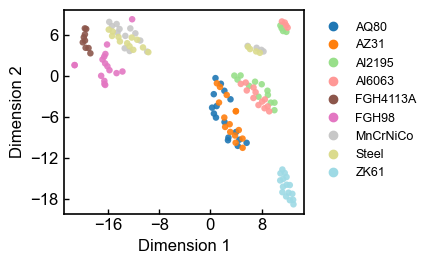

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


# from umap import UMAP
mpl.rcParams.update({
    "font.family": "Arial",
    "font.size": 12,
    "axes.linewidth": 1.2,
    "axes.labelsize": 12,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "legend.frameon": False,
})


def plot_tsne_latent(X, labels, title):

    X_std = StandardScaler().fit_transform(X)

    print(X_std.shape)

    tsne = TSNE(n_components=2, perplexity=20)
    X_2d = tsne.fit_transform(X_std)
    
    
    num_classes = len(np.unique(labels))

    #  colormap（tab20 → higher contrast Glasbey）
    try:
        import colorcet as cc
        cmap = cc.glasbey  
    except:
        cmap = plt.get_cmap("tab20", num_classes)


    fig, ax = plt.subplots(figsize=(4.5, 2.8))  

    sc = ax.scatter(
        X_2d[:, 0], X_2d[:, 1],
        c=labels,
        cmap=cmap,
        s=22,
        alpha=0.9,
        edgecolors="none"
    )


    # Legend
    handles = [
        plt.Line2D([], [], marker="o", linestyle="", markersize=6,
                   color=cmap(i), label=le.classes_[i])
        for i in range(num_classes)
    ]

    ax.legend(
        handles=handles,
        loc='upper left',
        bbox_to_anchor=(1.02, 1.0),
        fontsize=9,
        frameon=False,
        ncol=max(1, num_classes // 10),
    )



    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    # ax.set_title(title, fontsize=13, pad=6)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.tick_params(axis='x', which='both', bottom=True, top=False)
    ax.tick_params(axis='y', which='both', left=True, right=False)  

    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    

    plt.tight_layout()
    
    plt.savefig("plots/fig_3/latent_tsne_"+title+".png", dpi=500)
    plt.show()

plot_tsne_latent(all_z, label_ids, "tsne-latent")

In [5]:
from pathlib import Path
from typing import List
import pandas as pd

file_names = "ZK61"

path = "./alloy_dataset/"+file_names+"_LOO/merged_data"

def collect_csv_files(root: Path) -> List[Path]:
    csvs = [p for p in root.rglob("*.csv")]
    return sorted(csvs)
# 读取文件夹中的 csv 文件，将y_true列提取出来，保存为 numpy 数组
all_files = collect_csv_files(Path(path))
y_true_list = []
for file in all_files:
    df = pd.read_csv(file)
    y_true = df['y_true'].values
    y_true_list.append(y_true)
y_true_all = np.array(y_true_list)  # shape: (n_samples, n_points)
np.save("plots/fig_3/y_true_all_"+file_names+".npy", y_true_all)


Loading: y_true_all_Al2195.npy | label = Al2195
Loading: y_true_all_Al6063.npy | label = Al6063
Loading: y_true_all_AQ80.npy | label = AQ80
Loading: y_true_all_AZ31.npy | label = AZ31
Loading: y_true_all_FGH4113A.npy | label = FGH4113A
Loading: y_true_all_FGH98.npy | label = FGH98
Loading: y_true_all_MnCrNiCo.npy | label = MnCrNiCo
Loading: y_true_all_Steel.npy | label = Steel
Loading: y_true_all_ZK61.npy | label = ZK61
Total samples: 136
Data dim = 20

Mapping (label → id):
AQ80: 0
AZ31: 1
Al2195: 2
Al6063: 3
FGH4113A: 4
FGH98: 5
MnCrNiCo: 6
Steel: 7
ZK61: 8
TSNE input: (136, 20)


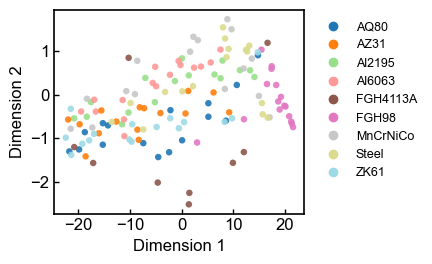

In [6]:
import torch
import numpy as np
import os
from pathlib import Path

npy_root = Path("plots/fig_3")

all_ydata = []
all_labels = []     # Alloy 名称标签

# ---------------------------------------
# 遍历文件夹下所有 y_true_all_*.npy
# ---------------------------------------
for file in npy_root.glob("y_true_all_*.npy"):
    alloy_name = file.stem.replace("y_true_all_", "")   # e.g. fgh4113A

    print("Loading:", file.name, "| label =", alloy_name)

    y = np.load(file)      # shape = (N, D)

    n = y.shape[0]
    all_ydata.append(y)
    all_labels.extend([alloy_name] * n)


# 合并所有 npy 数据
all_ydata = np.vstack(all_ydata)
all_labels = np.array(all_labels)

print("Total samples:", len(all_labels))
print("Data dim =", all_ydata.shape[1])


# ======================================
# 标签编码
# ======================================
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_ids = le.fit_transform(all_labels)

print("\nMapping (label → id):")
for name, i in zip(le.classes_, range(len(le.classes_))):
    print(f"{name}: {i}")


# ======================================
# t-SNE 绘图（复用你的函数）
# ======================================
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


mpl.rcParams.update({
    "font.family": "Arial",
    "font.size": 12,
    "axes.linewidth": 1.2,
    "axes.labelsize": 12,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "legend.frameon": False,
})


def plot_tsne_npy(X, labels, title):
    # 标准化
    X_std = StandardScaler().fit_transform(X)

    print("TSNE input:", X_std.shape)

    tsne = TSNE(n_components=2, perplexity=20)
    X_2d = tsne.fit_transform(X_std)

    num_classes = len(np.unique(labels))

    # Glasbey 颜色映射（如有 colorcet）
    try:
        import colorcet as cc
        cmap = cc.glasbey
    except:
        cmap = plt.get_cmap("tab20", num_classes)

    fig, ax = plt.subplots(figsize=(4.5, 2.8))

    sc = ax.scatter(
        X_2d[:, 0], X_2d[:, 1],
        c=labels,
        cmap=cmap,
        s=22,
        alpha=0.9,
        edgecolors="none"
    )

    # Legend
    handles = [
        plt.Line2D([], [], marker="o", linestyle="", markersize=6,
                   color=cmap(i), label=le.classes_[i])
        for i in range(num_classes)
    ]

    ax.legend(
        handles=handles,
        loc='upper left',
        bbox_to_anchor=(1.02, 1.0),
        fontsize=9,
        frameon=False,
        ncol=max(1, num_classes // 10),
    )

    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.tick_params(axis='x', which='both', bottom=True, top=False)
    ax.tick_params(axis='y', which='both', left=True, right=False)  
    plt.tight_layout()
    plt.savefig("plots/fig_3/tsne_ytrue_" + title + ".png", dpi=500)
    plt.show()


# ======================================
# 执行绘图
# ======================================
plot_tsne_npy(all_ydata, label_ids, "ytrue")


